# Richter's Predictor: Modeling Earthquake Damage

#### Datadriven is hosting a competition to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal based on aspects of building location and construction.

#### I took part of the competion with this script and obtained a micro-averaged F1 score of 0.7289 (Position 381 out of 2980).

#### More information can be found in the following [link]
[link]: https://www.drivendata.org/competitions/57/nepal-earthquake/

In [34]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import copy
import math
from sklearn.model_selection import cross_val_score

In [35]:
path = r"C:\Users\usuario\Desktop"
train_X = dd.read_csv(path + "/train_values.csv")
train_y = dd.read_csv(path + "/train_labels.csv")
test_x = dd.read_csv(path + "/test_values.csv")

df = train_X.merge(train_y, how="inner", on = "building_id")
sample = df.sample(frac=1, random_state=12).compute()

In [36]:
object_list = list(sample.select_dtypes("object").columns)
print(object_list)

['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


#### After analyzing the columns and their meaning, we decide to remove those related to the secondary purpose of the building because it has no impact in the damage.

In [37]:
colToDrop = []
for col in sample.columns:
    if "secondary" in col:
        colToDrop.append(col)
sample.drop(colToDrop, axis=1, inplace=True)

#### Let's see if the dataset is balanced:

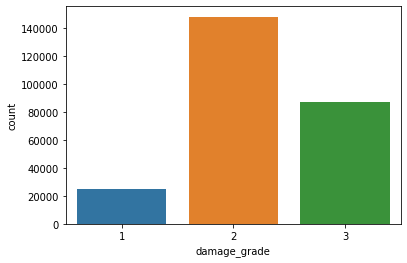

In [38]:
sns.countplot(x='damage_grade', data=sample)

#### We can clearly see that the dataset is not balanced. However, after working on the prediction of the damages we can see that we get a better result with this dataset, rather than an oversampled or undersampled one, so we will keep it like that.

#### Next step will be to get the dummy variables for the categorical ones:

In [39]:
sample = pd.get_dummies(sample)

#### We are ready to prepare the dataset in order to work on the prediction:

In [40]:
X = sample.loc[:,sample.columns != "damage_grade"].values
y = sample.loc[:,sample.columns == "damage_grade"].values

#### Due to the fact that there are a lot of features and most of them won't have any impact on the prediction, we will perform a feature selection to work with the most significant ones:

In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
selector = SelectKBest(chi2, k=2)
X = selector.fit_transform(X, y)

#### We split the dataset to train the model with some of the data and to test it with some different data:

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

#### The best result for this case is obtained with the Gradientboost:

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
grid_search = GradientBoostingClassifier(learning_rate=0.15,max_depth=5, min_samples_split=1200, n_estimators= 300, verbose = 1)
grid_search.fit(X_train, y_train.flatten())
y_pred = grid_search.predict(X_test)
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred, average='micro')

      Iter       Train Loss   Remaining Time 
         1      188367.0942            8.39m
         2      186827.1132            7.26m
         3      185607.0221            6.86m
         4      184639.4890            6.60m
         5      183864.3483            6.77m
         6      183013.9166            6.66m
         7      182534.9280            6.68m
         8      181589.6846            6.63m
         9      181039.7512            6.72m
        10      180567.0186            6.63m
        20      176393.1607            6.26m
        30      172917.1500            6.15m
        40      169905.6754            5.87m
        50      167451.1060            5.59m
        60      165397.3164            5.38m
        70      163573.0469            5.17m
        80      162247.2159            4.95m
        90      161094.5303            4.71m
       100      160042.0403            4.47m
       200      153071.1052            2.27m
       300      149266.7486            0.00s


#### Let's take a look at the confusion matrix:

In [44]:
from sklearn.metrics import confusion_matrix
conf_matriz = confusion_matrix(y_test, y_pred)

#### Last step is to save the results correctly to upload the file to the Drivendata website to get the results of our prediction:

In [45]:
test_x = pd.read_csv(path + "/test_values.csv")
test_data = pd.get_dummies(test_x)

for elem in test_data.columns:
  if elem not in sample.columns:
      test_data.drop(elem, axis=1, inplace=True)

test_data = selector.transform(test_data)       

In [47]:
y_pred_test = grid_search.predict(test_data)
y_pred_test = pd.DataFrame(y_pred_test, columns = ["damage_grade"])
building = test_x.loc[:,"building_id"]
building = pd.DataFrame(building, columns = ["building_id"])
solucion = pd.concat([building, y_pred_test], axis = 1)

solucion.to_csv(path +'/solution.csv', index = False)